# Calculate Shortest Path and Generate OD Matrx
This notebook 
* attribute farms to road network nodes
* calculate all-pair shortest paths between farms and all potential digester locations
* save the OD matrix (C_ij) as dictionary {p0: {f0: distance, f1: distance}...}

In [1]:
from cflp_function import store_data_to_pickle
import matplotlib as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

In [2]:
%matplotlib inline

## 1. Farms to Nodes (QGIS)

In [8]:
farm = pd.read_csv('./farm_mock.csv')
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [15]:
potential_plant_location = pd.read_csv('./farm_cluster_mock_5.csv')
potential_plant_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [6]:
nearest_neighbor = pd.read_csv('./osm_network/nearest_neighbor.csv')
nearest_neighbor.head()

,InputID,TargetID,Distance
0,507920,528,286.673776
1,507950,845,811.058871
2,507953,655,949.973658
3,507962,855,1048.825422
4,507964,195,662.103623


Here I should be loading set P from another file, I meant the file that has the indices of nodes representing the potential digester location

In [12]:
nearest_neighbor_p = pd.read_csv('./osm_network/nearest_neighbor_p.csv')
nearest_neighbor_p.head()

,InputID,TargetID,Distance
0,6.870686,125,332.611924
1,6.554937,190,2133.896966
2,6.730518,134,702.733217
3,6.914234,975,1375.746295
4,6.664105,790,728.068584


In [13]:
nearest_neighbor = nearest_neighbor.rename(columns={"TargetID": "osmid"})

In [14]:
merged_df = pd.merge(farm, nearest_neighbor, how='left', left_on="IND_OBJ_NA", right_on='InputID')
merged_df.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3,InputID,osmid,Distance
0,0,6.765843,52.314139,507920,2454,957060.0,507920,528,286.673776
1,1,6.837249,52.425084,507950,9827,3832530.0,507950,845,811.058871
2,2,6.859361,52.386225,507953,8660,3377400.0,507953,655,949.973658
3,3,6.753483,52.434382,507962,2913,1136070.0,507962,855,1048.825422
4,4,6.484077,52.243620,507964,6488,2530320.0,507964,195,662.103623


In [16]:
potential_plant_location['osmid'] = nearest_neighbor_p['TargetID']

In [17]:
potential_plant_location

,x,y,count,osmid
0,6.870686,52.215190,25,125
1,6.554937,52.254895,25,190
2,6.730518,52.252885,42,134
3,6.914234,52.387401,18,975
4,6.664105,52.392622,32,790


## 2. Calculate OD Matrix
Inputs:
* Road network with farm information at nodes 
* Set of potential digester locations 

In [18]:
g = ox.load_graphml('./osm_network/G.graphml') 

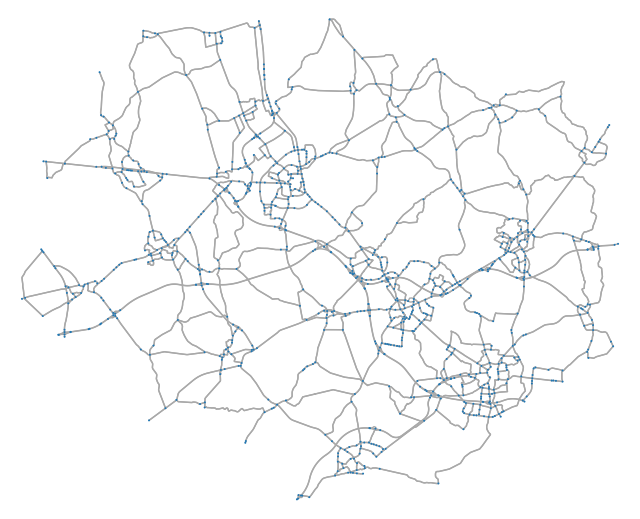

In [19]:
fig, ax = ox.plot_graph(g, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')

In [5]:
n, e = ox.graph_to_gdfs(g)

In [20]:
orig = merged_df['osmid'].unique().tolist()

In [21]:
dest = potential_plant_location['osmid'].unique().tolist()

In [17]:
# Initialize an empty OD matrix
od_matrix = {}

In [19]:
for origin in orig:
    od_matrix[origin] = {}
    for destination in dest:
        distance = nx.shortest_path_length(g, origin, destination, weight='length')
        od_matrix[origin][destination] = distance/1000 # convert from m to km

In [20]:
merged_df['osmid'].value_counts()

osmid
845    6
486    4
961    4
333    3
739    3
      ..
874    1
150    1
54     1
578    1
505    1
Name: count, Length: 99, dtype: int64

In [21]:
od_matrix

{528: {125: 24.38013393505244,
  190: 27.69527117195013,
  134: 15.593838742840918,
  975: 23.62720894186127,
  790: 20.926694608852713},
 845: {125: 44.82143009758931,
  190: 53.405683876380735,
  134: 41.30425144727152,
  975: 11.393033134341938,
  790: 28.203696468836792},
 655: {125: 33.44961170516485,
  190: 42.03386548395628,
  134: 29.932433054847067,
  975: 9.288614629855118,
  790: 28.282320596118236},
 855: {125: 47.991572463088616,
  190: 48.83008561974004,
  134: 36.70906300701628,
  975: 20.77206655096697,
  790: 18.320085710548476},
 195: {125: 42.5459227986963,
  190: 8.540405399649853,
  134: 24.61503911992708,
  975: 57.84428951768395,
  790: 39.60958931797318},
 226: {125: 39.73493178519619,
  190: 5.729414386149746,
  134: 21.80404810642697,
  975: 57.04004226811188,
  790: 32.08841644590519},
 81: {125: 41.15047701292046,
  190: 7.144959613874018,
  134: 23.21959333415124,
  975: 58.455587495836156,
  790: 38.21414353219734},
 643: {125: 29.337833444619026,
  190: 4

In [22]:
# Initialize an empty nested dictionary
new_nested_dict = {}

In [23]:
# Create a new nested dictionary with DataFrame index as keys
for idx, row in merged_df.iterrows():
    osmid_value = row['osmid']
    if osmid_value in od_matrix:
        new_nested_dict[idx] = od_matrix[osmid_value]

In [24]:
# # Sample nested dictionary
# nested_dict = {
#     'key1': {'subkey1': 10, 'subkey2': 20},
#     'key2': {'subkey1': 30, 'subkey2': 40}
# }

# Transform the nested dictionary
transportation_cost = {}
for outer_key, inner_dict in new_nested_dict.items():
    for inner_key, value in inner_dict.items():
        if inner_key not in transportation_cost:
            transportation_cost[inner_key] = {outer_key: value}
        else:
            transportation_cost[inner_key][outer_key] = value

In [25]:
transportation_cost = {i: transportation_cost[key] for i, key in enumerate(transportation_cost)}

In [26]:
# Print the new nested dictionary
print("New Nested Dictionary:")
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

New Nested Dictionary:
0: {0: 24.38013393505244, 1: 44.82143009758931, 2: 33.44961170516485, 3: 47.991572463088616, 4: 42.5459227986963, 5: 39.73493178519619, 6: 39.73493178519619, 7: 39.73493178519619, 8: 41.15047701292046, 9: 29.337833444619026, 10: 60.81339182995623, 11: 35.7884586839528, 12: 35.7884586839528, 13: 35.7884586839528, 14: 8.796940073272545, 15: 8.755954253178963, 16: 5.3600297097658895, 17: 6.883862946658534, 18: 6.957726149871625, 19: 10.03842681340373, 20: 12.144326369198728, 21: 44.82143009758931, 22: 41.54051845695836, 23: 6.286203099335466, 24: 17.9370599456493, 25: 30.200415744774368, 26: 14.677924810866942, 27: 16.845907393373054, 28: 17.94268674393164, 29: 12.723865117678855, 30: 22.693274345645236, 31: 28.922735935052437, 32: 45.500082945093155, 33: 25.016404311655535, 34: 25.984618478339137, 35: 35.85481511049894, 36: 36.260273110498936, 37: 24.703634513580283, 38: 31.076052701917913, 39: 21.01192676649167, 40: 15.925104529618213, 41: 17.497717906729996, 42: 

In [27]:
cost_per_km = 0.69

# Function to multiply values in nested dictionary by 0.69
def multiply_dict_values(d, cost_per_km = cost_per_km):
    for k, v in d.items():
        if isinstance(v, dict):
            multiply_dict_values(v)
        else:
            d[k] = v * cost_per_km

In [28]:
# Multiply all values in the nested dictionary by 0.69
multiply_dict_values(transportation_cost)

In [29]:
# Print the new nested dictionary
print("New Nested Dictionary:")
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

New Nested Dictionary:
0: {0: 16.822292415186183, 1: 30.92678676733662, 2: 23.080232076563743, 3: 33.11418499953114, 4: 29.356686731100446, 5: 27.41710293178537, 6: 27.41710293178537, 7: 27.41710293178537, 8: 28.393829138915116, 9: 20.243105076787128, 10: 41.9612403626698, 11: 24.694036491927427, 12: 24.694036491927427, 13: 24.694036491927427, 14: 6.069888650558055, 15: 6.041608434693484, 16: 3.6984204997384635, 17: 4.749865433194389, 18: 4.800831043411421, 19: 6.9265145012485725, 20: 8.379585194747122, 21: 30.92678676733662, 22: 28.662957735301266, 23: 4.337480138541471, 24: 12.376571362498016, 25: 20.83828686389431, 26: 10.127768119498189, 27: 11.623676101427407, 28: 12.380453853312831, 29: 8.77946693119841, 30: 15.658359298495212, 31: 19.95668779518618, 32: 31.395057232114276, 33: 17.261318975042318, 34: 17.929386750054004, 35: 24.739822426244267, 36: 25.019588446244263, 37: 17.045507814370396, 38: 21.44247636432336, 39: 14.49822946887925, 40: 10.988322125436566, 41: 12.073425355643

In [30]:
transportation_cost

{0: {0: 16.822292415186183,
  1: 30.92678676733662,
  2: 23.080232076563743,
  3: 33.11418499953114,
  4: 29.356686731100446,
  5: 27.41710293178537,
  6: 27.41710293178537,
  7: 27.41710293178537,
  8: 28.393829138915116,
  9: 20.243105076787128,
  10: 41.9612403626698,
  11: 24.694036491927427,
  12: 24.694036491927427,
  13: 24.694036491927427,
  14: 6.069888650558055,
  15: 6.041608434693484,
  16: 3.6984204997384635,
  17: 4.749865433194389,
  18: 4.800831043411421,
  19: 6.9265145012485725,
  20: 8.379585194747122,
  21: 30.92678676733662,
  22: 28.662957735301266,
  23: 4.337480138541471,
  24: 12.376571362498016,
  25: 20.83828686389431,
  26: 10.127768119498189,
  27: 11.623676101427407,
  28: 12.380453853312831,
  29: 8.77946693119841,
  30: 15.658359298495212,
  31: 19.95668779518618,
  32: 31.395057232114276,
  33: 17.261318975042318,
  34: 17.929386750054004,
  35: 24.739822426244267,
  36: 25.019588446244263,
  37: 17.045507814370396,
  38: 21.44247636432336,
  39: 14.498

In [32]:
store_data_to_pickle(transportation_cost, 'app_data', 'transportation_cost.pickle')